In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
from __future__ import annotations

import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro_glm.utils.dist as dist_utils
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs

numpyro.set_host_device_count(4)

# Chapter 10: Model Comparison and Hierarchical Modeling
## Solution by MCMC
### Nonhierarchical MCMC Computation of each model's Marginal Likelihood

#### Implementation

In [3]:
def model(y: jnp.ndarray):
    nb_obs = y.shape[0]

    theta = numpyro.sample(
        'theta', dist_utils.beta_dist_from_omega_kappa(0.75, 12))

    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Bernoulli(theta), obs=y[idx])


kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.r_[jnp.zeros(3), jnp.ones(6)],
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.69      0.10      0.70      0.53      0.85  28211.01      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

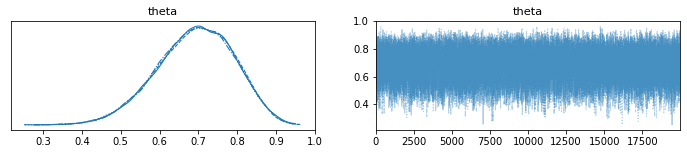

In [4]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

Compute $p(D)$ by following equation 10.8.

In [5]:
from scipy.stats import beta  # noqa

theta = idata['posterior']['theta'].values.flatten()
theta_mean = np.mean(theta)
theta_sd = np.std(theta)

# Convert mean, std to a and b of Beta distribution.
sd_squared = theta_sd**2
a_posterior = theta_mean * (theta_mean * (1 - theta_mean) / sd_squared - 1)
b_posterior = (1 - theta_mean) * (theta_mean *
                                  (1 - theta_mean) / sd_squared - 1)
one_over_pD = np.mean(beta.pdf(theta, a_posterior, b_posterior)
                      / (theta**6 * (1-theta)**3
                         * beta.pdf(theta, 0.75 * (12 - 2) + 1, (1 - 0.75) * (12 - 2) + 1)))
print(1. / one_over_pD)

0.0023383240897058436


### Hierarchical MCMC Computation of Relative Model Probability

In [6]:
def model_hier(y: jnp.ndarray):
    nb_obs = y.shape[0]

    model_prior = jnp.array([0.5, 0.5])
    m = numpyro.sample('m', dist.Categorical(model_prior))

    omega = jnp.array([0.25, 0.75])
    kappa = 12

    theta = numpyro.sample(
        'theta', dist_utils.beta_dist_from_omega_kappa(omega[m], kappa))

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Bernoulli(theta), obs=y[idx])


kernel = DiscreteHMCGibbs(NUTS(model_hier))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.r_[jnp.zeros(3), jnp.ones(6)],
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      0.82      0.39      1.00      0.00      1.00  14107.03      1.00
     theta      0.65      0.14      0.67      0.42      0.86  12107.18      1.00



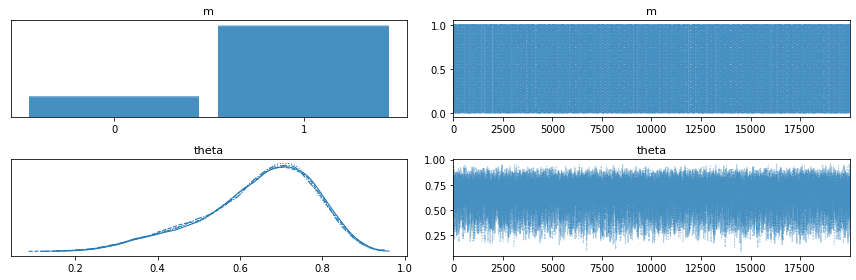

In [7]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)
plt.tight_layout()

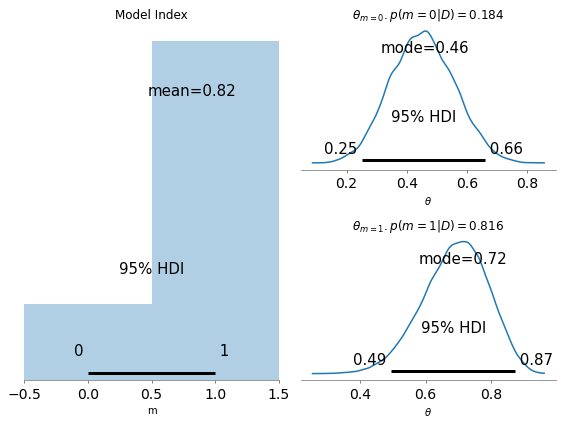

In [8]:
fig: plt.Figure = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(nrows=2, ncols=2)

# Plot model index.
m = idata['posterior']['m'].values.flatten()
ax = fig.add_subplot(gs[:, 0])
az.plot_posterior(m, hdi_prob=.95, point_estimate='mean', ax=ax)
ax.set_title('Model Index')
ax.set_xlabel('m')

# Plot theta's posterior of the first model (m = 0).
# Index 0 corresponds to index 1 in R.
theta = idata['posterior']['theta'].values.flatten()
theta_m_0 = theta[m == 0]
p_m_0 = np.sum(m == 0) / m.size
ax = fig.add_subplot(gs[0, 1])
az.plot_posterior(theta_m_0, hdi_prob=.95, point_estimate='mode', ax=ax)
ax.set_title(f'$\\theta_{{m = 0}}. p(m = 0| D) = {p_m_0:.3f}$')
ax.set_xlabel('$\\theta$')

# Plot theta's posterior of the second model (m = 1).
# Index 1 corresponds to index 2 in R.
theta = idata['posterior']['theta'].values.flatten()
theta_m_1 = theta[m == 1]
p_m_1 = np.sum(m == 1) / m.size
ax = fig.add_subplot(gs[1, 1])
az.plot_posterior(theta_m_1, hdi_prob=.95, point_estimate='mode', ax=ax)
ax.set_title(f'$\\theta_{{m = 1}}. p(m = 1| D) = {p_m_1:.3f}$')
ax.set_xlabel('$\\theta$')

fig.tight_layout()

#### Using pseudo-priors to reduce autocorrelation
##### Without Pseudo-Priors

Data

In [9]:
N = 30
z = int(np.ceil(N * .55))
y = jnp.r_[jnp.zeros(N - z), jnp.ones(z)]

In [10]:
def model_hier_2(y: jnp.ndarray):
    nb_obs = y.shape[0]

    model_prior = jnp.array([0.5, 0.5])
    m = numpyro.sample('m', dist.Categorical(model_prior))

    # Prior for theta 0 (corresponds to theta1 in the book).
    theta0 = numpyro.sample(
        'theta0', dist_utils.beta_dist_from_omega_kappa(.10, 20))

    # Prior for theta 1 (corresponds to theta2 in the book).
    theta1 = numpyro.sample(
        'theta1', dist_utils.beta_dist_from_omega_kappa(.90, 20))

    # Theta will be based on how the m is.
    theta = numpyro.deterministic('theta', jnp.where(m == 0, theta0, theta1))

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Bernoulli(theta), obs=y[idx])


kernel = DiscreteHMCGibbs(NUTS(model_hier_2))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      0.92      0.27      1.00      1.00      1.00   3003.79      1.00
    theta0      0.16      0.10      0.14      0.02      0.31   5646.72      1.00
    theta1      0.70      0.08      0.69      0.56      0.81   6324.01      1.00



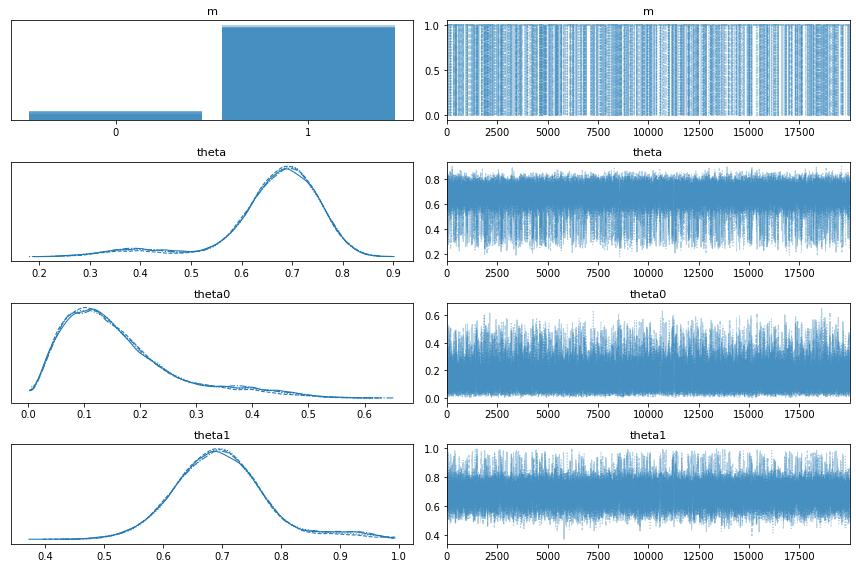

In [11]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)
plt.tight_layout()

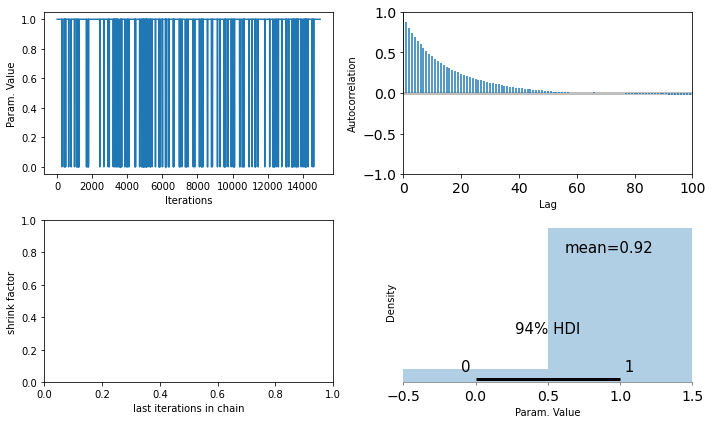

In [12]:
def plot_diagnostic(data, last_iterations=15000):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    if data.ndim > 1:
        data = data.flatten()

    # Plot trace.
    ax = axes[0, 0]
    ax.plot(np.arange(last_iterations), data[-last_iterations:])
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Param. Value')

    # Plot autocorrelation.
    ax = axes[0, 1]
    az.plot_autocorr(data, ax=ax)
    ax.set_title('')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')

    # Plot shrink factor.
    ax = axes[1, 0]
    # TODO
    ax.set_xlabel('last iterations in chain')
    ax.set_ylabel('shrink factor')

    # Plot posterior.
    ax = axes[1, 1]
    az.plot_posterior(data, ax=ax)
    ax.set_title('')
    ax.set_xlabel('Param. Value')
    ax.set_ylabel('Density')

    fig.tight_layout()


plot_diagnostic(idata['posterior']['m'].values)

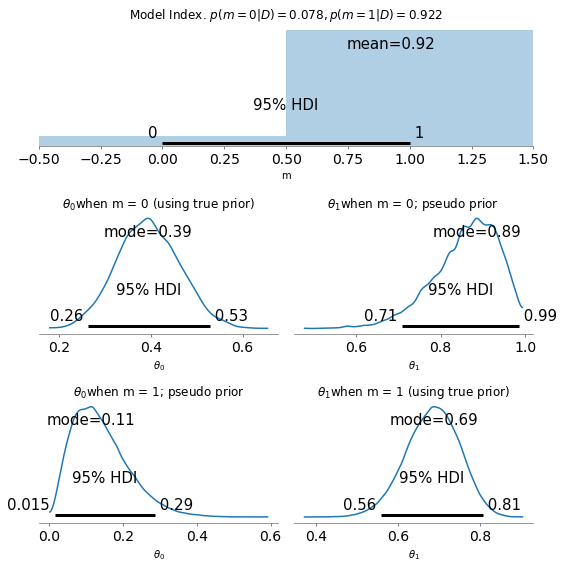

In [13]:
def plot_hierarchical_model_index_and_theta(idata: az.InferenceData):
    fig: plt.Figure = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(nrows=3, ncols=2)

    posterior = idata['posterior']

    # Model index.
    m = posterior['m'].values.flatten()
    p0 = np.sum(m == 0) / m.size
    p1 = np.sum(m == 1) / m.size

    ax = fig.add_subplot(gs[0, :])
    az.plot_posterior(m, hdi_prob=.95, point_estimate='mean', ax=ax)
    ax.set_title('Model Index. '
                 f'$p(m=0|D) = {p0:.3f}, p(m=1|D) = {p1:.3f}$')
    ax.set_xlabel('m')

    # theta0 when m = 0 (posterior distribution).
    theta0 = posterior['theta0'].values.flatten()
    theta0_m0 = theta0[m == 0]
    ax = fig.add_subplot(gs[1, 0])
    az.plot_posterior(theta0_m0, hdi_prob=.95, point_estimate='mode', ax=ax)
    ax.set_title('$\\theta_0$'
                 'when m = 0 (using true prior)')
    ax.set_xlabel('$\\theta_0$')

    # theta0 when m = 1 (prior distribution).
    theta0_m1 = theta0[m == 1]
    ax = fig.add_subplot(gs[2, 0])
    az.plot_posterior(theta0_m1, hdi_prob=.95, point_estimate='mode', ax=ax)
    ax.set_title('$\\theta_0$'
                 'when m = 1; pseudo prior')
    ax.set_xlabel('$\\theta_0$')

    # theta1 when m = 0 (prior distribution).
    theta1 = posterior['theta1'].values.flatten()
    theta1_m0 = theta1[m == 0]
    ax = fig.add_subplot(gs[1, 1])
    az.plot_posterior(theta1_m0, hdi_prob=.95, point_estimate='mode', ax=ax)
    ax.set_title('$\\theta_1$'
                 'when m = 0; pseudo prior')
    ax.set_xlabel('$\\theta_1$')

    # theta1 when m = 1 (posterior distribution).
    theta1_m1 = theta1[m == 1]
    ax = fig.add_subplot(gs[2, 1])
    az.plot_posterior(theta1_m1, hdi_prob=.95, point_estimate='mode', ax=ax)
    ax.set_title('$\\theta_1$'
                 'when m = 1 (using true prior)')
    ax.set_xlabel('$\\theta_1$')

    fig.tight_layout()


plot_hierarchical_model_index_and_theta(idata)

In this case, the MCMC runs just fine without pseudo-priors.
But you will see the problem in the model in chapter 12,
hence explains the use of pseudo-priors in that model.

##### With Pseudo-Priors

In [14]:
def model_hier_pseudo_priors(y: jnp.ndarray):
    nb_obs = y.shape[0]

    # Specify prior for model index.
    model_prior = jnp.array([0.5, 0.5])
    m = numpyro.sample('m', dist.Categorical(model_prior))

    # Specify prior for theta0.
    omega0 = jnp.r_[.1, .4]  # (true, pseudo)
    kappa0 = jnp.r_[20, 50]  # (true, pseudo)
    theta0 = numpyro.sample(
        'theta0', dist_utils.beta_dist_from_omega_kappa(omega0[m], kappa0[m]))

    # Specify prior for theta1.
    # Also, notices that the position of true and pseudo priors have changed.
    omega1 = jnp.r_[.7, .9]  # (pseudo, true)
    kappa1 = jnp.r_[50, 20]  # (pseudo, true)
    theta1 = numpyro.sample(
        'theta1', dist_utils.beta_dist_from_omega_kappa(omega1[m], kappa1[m]))

    # Theta depends on model index.
    theta = jnp.where(m == 0, theta0, theta1)

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Bernoulli(theta), obs=y[idx])


kernel = DiscreteHMCGibbs(NUTS(model_hier_pseudo_priors))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=y,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         m      0.92      0.27      1.00      1.00      1.00  79098.87      1.00
    theta0      0.40      0.07      0.40      0.29      0.52  72035.28      1.00
    theta1      0.68      0.06      0.69      0.58      0.79  68212.77      1.00



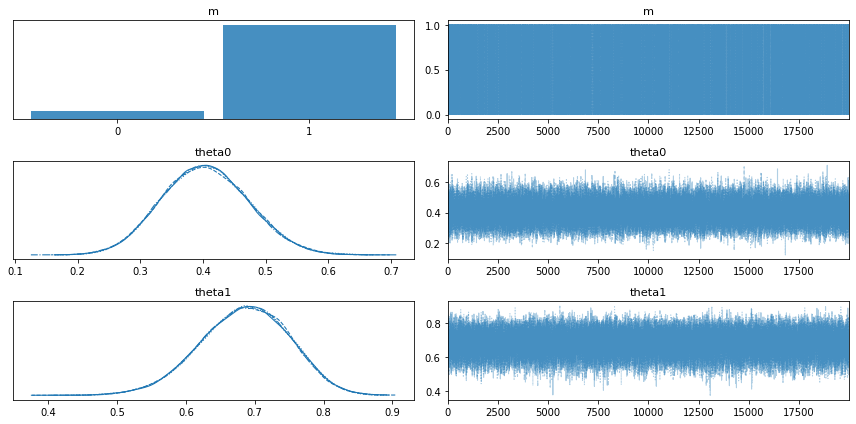

In [15]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)
plt.tight_layout()

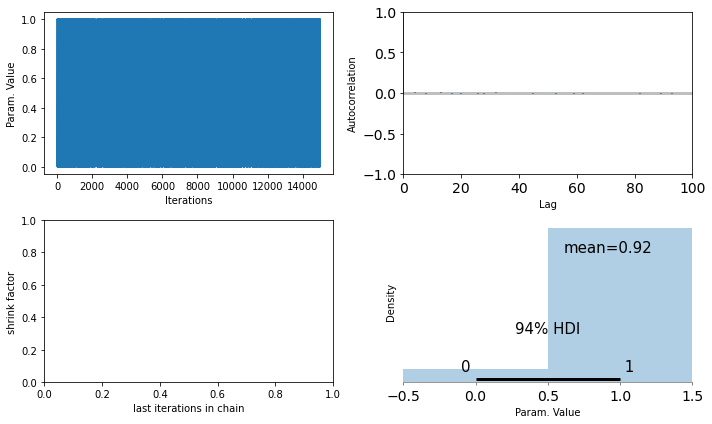

In [16]:
plot_diagnostic(idata['posterior']['m'].values)

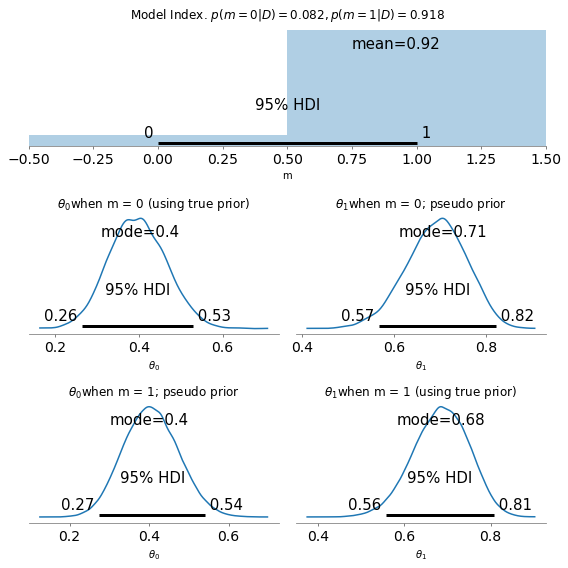

In [17]:
plot_hierarchical_model_index_and_theta(idata)